In [8]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import faiss
import os
from tqdm import tqdm
import random
from typing import List, Dict, Tuple

RNG = np.random.default_rng(42)
random.seed(42)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [3]:
def embed_image(image_path):
    img = Image.open(image_path).convert("RGB")
    inputs = processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        emb = model.get_image_features(**inputs)
    emb = emb.cpu().numpy()
    emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)
    return emb[0]

In [4]:
# Build index
pants_imgs = [f"./datasets/clothing-dataset-small/train/pants/{x}" for x in os.listdir("./datasets/clothing-dataset-small/train/pants")]
pants_imgs = [{
    "id": f"pants_{i}",
    "category": "pants",
    "path": p,
    "embedding": embed_image(p)
} for i, p in enumerate(pants_imgs)]
shirt_imgs = [f"./datasets/clothing-dataset-small/train/shirt/{x}" for x in os.listdir("./datasets/clothing-dataset-small/train/shirt")]
shirt_imgs = [{
    "id": f"shirt_{i}",
    "category": "shirt",
    "path": p,
    "embedding": embed_image(p)
} for i, p in enumerate(shirt_imgs)]

catalog = pants_imgs + shirt_imgs

In [5]:
def make_demo_outfit_pairs(catalog, n_pairs=200):
    shirts = [c for c in catalog if c["category"]=="shirt"]
    pants = [c for c in catalog if c["category"]=="pants"]
    pairs = []
    # create compatibility by making pants whose embeddings correlate with shirt embedding via a simple transform
    for _ in range(n_pairs):
        s = RNG.choice(shirts)
        # generate "true" compatible pants probabilistically: choose a pants whose embedding is close to a linear transform
        # This is just for demo; in real life pairs come from dataset or purchases
        # pick a pants with higher probability if cosine similarity > random threshold
        similarities = [np.dot(s["embedding"], p["embedding"]) for p in pants]
        # sample pants weighted by softmax of similarity
        logits = np.array(similarities)*10.0
        probs = np.exp(logits - logits.max())
        probs = probs / probs.sum()
        chosen = RNG.choice(len(pants), p=probs)
        pairs.append((s["id"], pants[chosen]["id"]))
    return pairs

In [6]:
outfit_pairs = make_demo_outfit_pairs(catalog, n_pairs=300)

In [9]:
# Build quick id -> entry map
catalog_map: Dict[str, Dict] = {c["id"]: c for c in catalog}

In [10]:
# ----------------------------
# 1) Unsupervised (co-occurrence + prototype) approach
# ----------------------------
# Idea:
#  - For each source item (shirt), make a compatibility prototype vector = average embedding of pants that co-occur with that shirt.
#  - Given a query shirt, compute cosine similarity between the shirt's prototype and all pants embeddings (or compute similarity between shirt embedding and pants prototype,
#    depending on what data you have). This returns compatible items without training a classifier.
#
# Pros: simple, fast, no training. Cons: needs co-occurrence pairs and can be noisy.
def build_prototypes_from_pairs(catalog: List[Dict], outfit_pairs: List[Tuple[str,str]],
                                source_cat="shirt", target_cat="pants"):
    # prototypes: mapping from source item id -> prototype embedding (mean of target embeddings it co-occurs with)
    prototypes = {}
    # collect target embeddings grouped by source id
    grouped = {}
    for a,b in outfit_pairs:
        a_entry = catalog_map.get(a)
        b_entry = catalog_map.get(b)
        if not a_entry or not b_entry:
            continue
        if a_entry["category"] == source_cat and b_entry["category"] == target_cat:
            grouped.setdefault(a, []).append(b_entry["embedding"])
        elif a_entry["category"] == target_cat and b_entry["category"] == source_cat:
            # pairs might be in either order
            grouped.setdefault(b, []).append(a_entry["embedding"])
    for src_id, emb_list in grouped.items():
        mat = np.vstack(emb_list)
        proto = mat.mean(axis=0)
        proto = proto / np.linalg.norm(proto)  # normalize
        prototypes[src_id] = proto
    return prototypes


In [11]:
def recommend_compatible_prototype(query_id: str, prototypes: Dict[str,np.ndarray],
                                   catalog: List[Dict], top_k=8, target_cat="pants"):
    if query_id not in prototypes:
        # fallback: return visually similar items (by embedding cosine) in target category
        q_emb = catalog_map[query_id]["embedding"]
        candidates = [c for c in catalog if c["category"]==target_cat]
        sims = [np.dot(q_emb, c["embedding"]) for c in candidates]
        idx = np.argsort(sims)[::-1][:top_k]
        return [candidates[i]["id"] for i in idx]
    proto = prototypes[query_id]
    candidates = [c for c in catalog if c["category"]==target_cat]
    sims = [np.dot(proto, c["embedding"]) for c in candidates]
    idx = np.argsort(sims)[::-1][:top_k]
    return [candidates[i]["id"] for i in idx]


In [12]:
# Build prototypes
prototypes = build_prototypes_from_pairs(catalog, outfit_pairs, source_cat="shirt", target_cat="pants")

In [13]:
# Demo query
demo_shirt = "shirt_3"
print("Prototype-based recommended pants for", demo_shirt, "->", recommend_compatible_prototype(demo_shirt, prototypes, catalog, 8))


Prototype-based recommended pants for shirt_3 -> ['pants_3', 'pants_122', 'pants_38', 'pants_242', 'pants_310', 'pants_57', 'pants_427', 'pants_341']


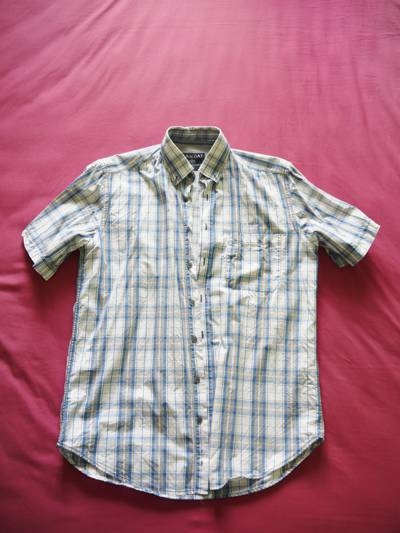

In [28]:
demo_path = list(filter(lambda c: c["id"] == demo_shirt, catalog))[0]["path"]
demo_img = Image.open(demo_path).convert("RGB")
demo_img

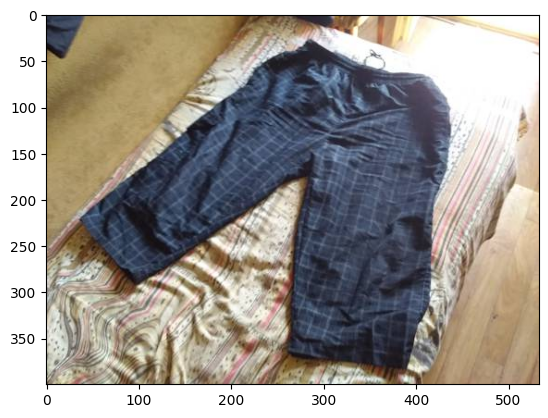

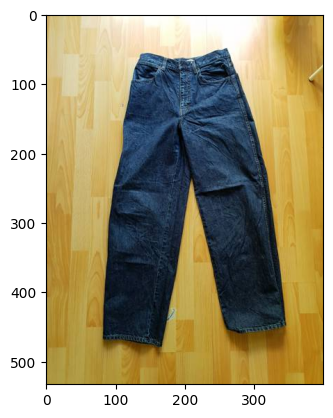

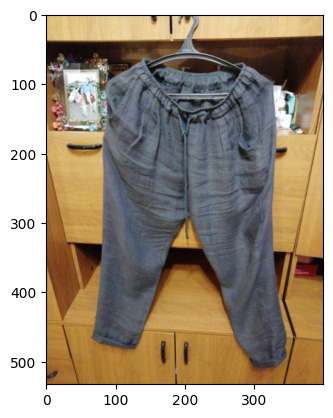

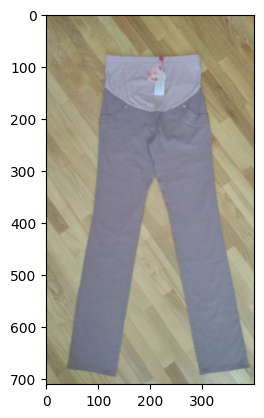

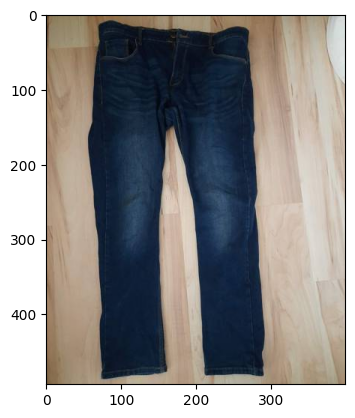

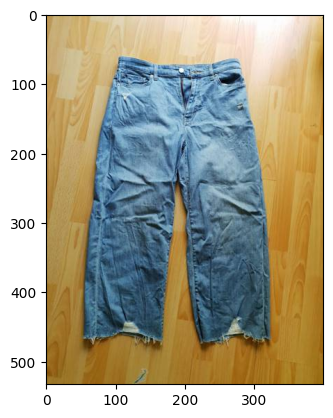

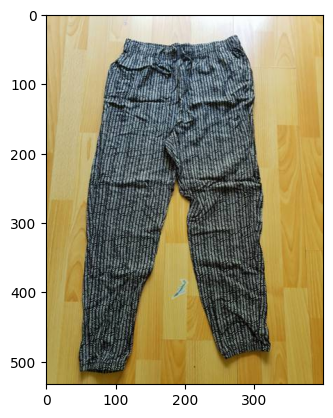

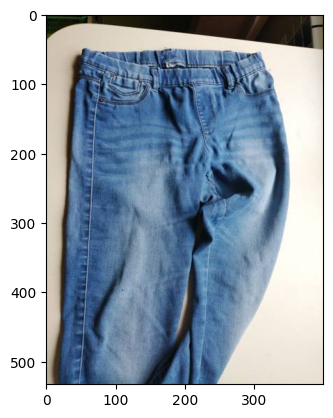

In [29]:
recs = ['pants_3', 'pants_122', 'pants_38', 'pants_242', 'pants_310', 'pants_57', 'pants_427', 'pants_341']
for rec in recs:
    p = list(filter(lambda c: c["id"] == rec, catalog))[0]["path"]
    img = Image.open(p).convert("RGB")
    plt.imshow(img)
    plt.show()

In [31]:
import cv2
import numpy as np
from PIL import Image

def simple_overlay(person_path, garment_path, garment_mask_path=None):
    person = cv2.imread(person_path, cv2.IMREAD_UNCHANGED)
    garment = cv2.imread(garment_path, cv2.IMREAD_UNCHANGED)  # RGBA ideally
    # detect torso bbox using e.g., simple heuristic or a keypoint detector
    # here: naively center garment on upper body; for demo use fixed scale
    ph, pw = person.shape[:2]
    gh, gw = garment.shape[:2]
    scale = 0.6  # tune
    new_w = int(pw * scale)
    new_h = int(gh * new_w / gw)
    garment_resized = cv2.resize(garment, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # compute position (example: center horizontally, at 25% from top)
    x = pw//2 - new_w//2
    y = int(ph*0.2)

    # If garment has alpha channel, use it as mask
    if garment_resized.shape[2] == 4:
        alpha = garment_resized[:,:,3]/255.0
        for c in range(3):
            person[y:y+new_h, x:x+new_w, c] = (alpha * garment_resized[:,:,c] +
                                               (1-alpha) * person[y:y+new_h, x:x+new_w, c])
    else:
        # fallback: simple overlay with constant alpha
        alpha = 0.8
        person[y:y+new_h, x:x+new_w,:3] = alpha*garment_resized[:,:,:3] + (1-alpha)*person[y:y+new_h, x:x+new_w,:3]

    plt.imshow(person)

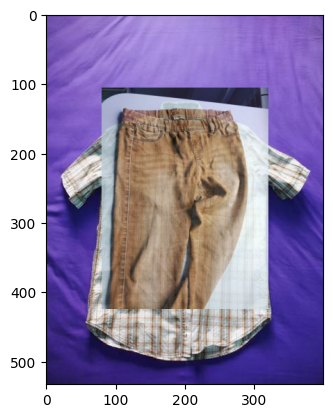

In [32]:
simple_overlay(demo_path, p)